In [42]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import parseTrackletXML as xmlParser
import os

#label_path = '/home/husky/data/kitti_object/data_object_image_2/training/label_2/'
#image_path = '/home/husky/data/kitti_object/data_object_image_2/training/image_2/'
#calib_path = '/home/husky/data/kitti_object/data_object_calib/training/calib/'

label_dir = '/home/husky/github/vehicle-detector/2011_09_26/2011_09_26_drive_0009_sync/predict_02/'
image_dir = '/home/husky/github/vehicle-detector/2011_09_26/2011_09_26_drive_0009_sync/image_02/data/'
calib_dir = '/home/husky/github/vehicle-detector/2011_09_26/2011_09_26_drive_0009_sync/calib_02/'

dataset = [name.split('.')[0] for name in sorted(os.listdir(label_dir))]

# Make the demonstration video

In [61]:
video_out = '/home/husky/data/kitti_3D.avi'
video_writer = None

all_image = sorted(os.listdir(image_dir))
#np.random.shuffle(all_image)

for f in all_image:
    image_file = image_dir + f
    calib_file = calib_dir + f.replace('png', 'txt')
    predi_file = predi_dir + f.replace('png', 'txt')

    # read calibration data
    for line in open(calib_file):
        if 'P2:' in line:
            cam_to_img = line.strip().split(' ')
            cam_to_img = np.asarray([float(number) for number in cam_to_img[1:]])
            cam_to_img = np.reshape(cam_to_img, (3,4))
        
    image = cv2.imread(image_file)
    cars = []
    
    if video_writer is None:
        fourcc = cv2.VideoWriter_fourcc(*'XVID')
        video_writer = cv2.VideoWriter(video_out, fourcc, 25.0, (1242, 375))

    # Draw 3D Bounding Box
    for line in open(predi_file):
        line = line.strip().split(' ')

        dims   = np.asarray([float(number) for number in line[8:11]])
        center = np.asarray([float(number) for number in line[11:14]])
        rot_y  = float(line[3]) + np.arctan(center[0]/center[2])#float(line[14])

        box_3d = []

        for i in [1,-1]:
            for j in [1,-1]:
                for k in [0,1]:
                    point = np.copy(center)
                    point[0] = center[0] + i * dims[1]/2 * np.cos(-rot_y+np.pi/2) + (j*i) * dims[2]/2 * np.cos(-rot_y)
                    point[2] = center[2] + i * dims[1]/2 * np.sin(-rot_y+np.pi/2) + (j*i) * dims[2]/2 * np.sin(-rot_y)                  
                    point[1] = center[1] - k * dims[0]

                    point = np.append(point, 1)
                    point = np.dot(cam_to_img, point)
                    point = point[:2]/point[2]
                    point = point.astype(np.int16)
                    box_3d.append(point)

        for i in xrange(4):
            point_1_ = box_3d[2*i]
            point_2_ = box_3d[2*i+1]
            cv2.line(image, (point_1_[0], point_1_[1]), (point_2_[0], point_2_[1]), (0,255,0), 2)

        for i in xrange(8):
            point_1_ = box_3d[i]
            point_2_ = box_3d[(i+2)%8]
            cv2.line(image, (point_1_[0], point_1_[1]), (point_2_[0], point_2_[1]), (0,255,0), 2)
                
    video_writer.write(np.uint8(image))

# Prepare Image and Prediction for Demo Video

In [41]:
image_dir = '/home/husky/github/vehicle-detector/2011_09_26/2011_09_26_drive_0009_sync/image_02/data/'
box2d_dir = '/home/husky/github/vehicle-detector/2011_09_26/2011_09_26_drive_0009_sync/box_2d/'
box3d_dir = '/home/husky/github/vehicle-detector/2011_09_26/2011_09_26_drive_0009_sync/box_3d/'
label_dir = '/home/husky/github/vehicle-detector/2011_09_26/2011_09_26_drive_0009_sync/label_02/'
calib_dir = '/home/husky/github/vehicle-detector/2011_09_26/2011_09_26_drive_0009_sync/calib_02/'
predi_dir = '/home/husky/github/vehicle-detector/2011_09_26/2011_09_26_drive_0009_sync/predict_02/'

all_image = sorted(os.listdir(image_dir))
#np.random.shuffle(all_image)

for f in all_image:
    image_file = image_dir + f
    box2d_file = box2d_dir + f.replace('png', 'txt')
    box3d_file = box3d_dir + f.replace('png', 'txt')
    label_file = label_dir + f.replace('png', 'txt')
    calib_file = calib_dir + f.replace('png', 'txt')
    predi_file = predi_dir + f.replace('png', 'txt')
    
    with open(predi_file, 'w') as prediction:
        # Construct list of all candidate centers
        centers_2d = []
        centers_3d = []

        for line in open(calib_file):
            if 'P2:' in line:
                cam_to_img = line.strip().split(' ')
                cam_to_img = np.asarray([float(number) for number in cam_to_img[1:]])
                cam_to_img = np.reshape(cam_to_img, (3,4))

        for line in open(label_file):
            line = line.strip().split(' ')

            center = np.asarray([float(number) for number in line[11:14]])
            center = np.append(center, 1)
            center = np.dot(cam_to_img, center)
            center = center[:2]/center[2]
            center = center.astype(np.int16)

            centers_2d.append(center)
            centers_3d.append(np.asarray([float(number) for number in line[11:14]]))

        # Find the nearest centres among the candidates
        for line in open(box3d_file):
            line = line.strip().split(' ')

            obj = {'xmin':int(float(line[4])),
                   'ymin':int(float(line[5])),
                   'xmax':int(float(line[6])),
                   'ymax':int(float(line[7])),}

            center = np.asarray([(obj['xmin']+obj['xmax'])/2., (obj['ymin'] + obj['ymax'])/2.])

            nearest_index = -1
            last_distance = 1000000000.

            for i in xrange(len(centers_2d)):
                candidate = centers_2d[i]
                distance = np.sum(np.square(center - candidate))

                if distance < 1000 and distance < last_distance:
                    nearest_index = i
                    last_distance = distance

            if nearest_index > -1:
                line += list(centers_3d[nearest_index])
                del centers_2d[nearest_index]
                del centers_3d[nearest_index]
                
                # Write regressed 3D dim and oritent to file
                line = ' '.join([str(item) for item in line]) + '\n'
                prediction.write(line)

# Prepare the test data

In [63]:
kittiDir = '/home/husky/github/vehicle-detector/2011_09_26/'
drive = '2011_09_26_drive_0009_sync/'

label_dir = kittiDir + drive + 'label_02/'
image_dir = kittiDir + drive + 'image_02/data/'
calib_dir = kittiDir + drive + 'calib_02/'

# FIGURE OUT THE LABELS
os.system('rm ' + label_dir + '*')
os.system('rm ' + calib_dir + '*')

# Read transformation matrices
for line in open(kittiDir + drive + 'calib_velo_to_cam.txt'):
    if 'R:' in line:
        R = line.strip().split(' ')
        R = np.asarray([float(number) for number in R[1:]])
        R = np.reshape(R, (3,3))
        
    if 'T:' in line:
        T = line.strip().split(' ')
        T = np.asarray([float(number) for number in T[1:]])
        T = np.reshape(T, (3,1))
        
for line in open(kittiDir + drive + 'calib_cam_to_cam.txt'):
    if 'R_rect_00:' in line:
        R0_rect = line.strip().split(' ')
        R0_rect = np.asarray([float(number) for number in R0_rect[1:]])
        R0_rect = np.reshape(R0_rect, (3,3))

R0_rect = np.append(R0_rect, np.zeros((3,1)), axis=1)
R0_rect = np.append(R0_rect, np.zeros((1,4)), axis=0)
R0_rect[-1,-1] = 1

Tr_velo_to_cam = np.concatenate([R,T],axis=1)
Tr_velo_to_cam = np.append(Tr_velo_to_cam, np.zeros((1,4)), axis=0)
Tr_velo_to_cam[-1,-1] = 1

transform = np.dot(R0_rect, Tr_velo_to_cam)

#print Tr_velo_to_cam
#print R0_rect
#print transform

# Read the tracklets
for trackletObj in xmlParser.parseXML(kittiDir + drive + 'tracklet_labels.xml'):
    for translation, rotation, state, occlusion, truncation, amtOcclusion, amtBorders, absoluteFrameNumber in trackletObj:
        label_file = label_dir + str(absoluteFrameNumber).zfill(10) + '.txt'
        
        translation = np.append(translation, 1)
        translation = np.dot(transform, translation)
        translation = translation[:3]/translation[3]
        
        with open(label_file, 'a') as file_writer:
            line = [trackletObj.objectType] + [0,0,rotation[2]] + [0,0,0,0] + list(trackletObj.size) + list(translation) + [rotation[2]]
            line = ' '.join([str(item) for item in line]) + '\n'
            file_writer.write(line)
            
# FIGURE OUT THE CALIBRATION
for line in open(kittiDir + drive + 'calib_cam_to_cam.txt'):
    if 'P_rect_02' in line:
        line_P2 = line.replace('P_rect_02', 'P2')
        print line_P2
        
for image in os.listdir(image_dir):
    label_file = label_dir + image.split('.')[0] + '.txt'
    calib_file = calib_dir + image.split('.')[0] + '.txt'
    
    # Create calib files
    with open(calib_file, 'w') as file_writer:
        file_writer.write(line_P2)
    
    # Fix missing lables
    with open(label_file, 'a') as file_writer:
        file_writer.write('')
        


parsing tracklet file /home/husky/github/vehicle-detector/2011_09_26/2011_09_26_drive_0009_sync/tracklet_labels.xml
file contains 98 tracklets
loaded 98 tracklets
P2: 7.215377e+02 0.000000e+00 6.095593e+02 4.485728e+01 0.000000e+00 7.215377e+02 1.728540e+02 2.163791e-01 0.000000e+00 0.000000e+00 1.000000e+00 2.745884e-03



283
-1.91526828805 [  4.45974643   1.72786479  22.37337955]
1.69883535902 [ -3.06264015   1.79187299  38.44854226]
-1.46855452011 [  5.08717029   1.76743288  33.24231977]


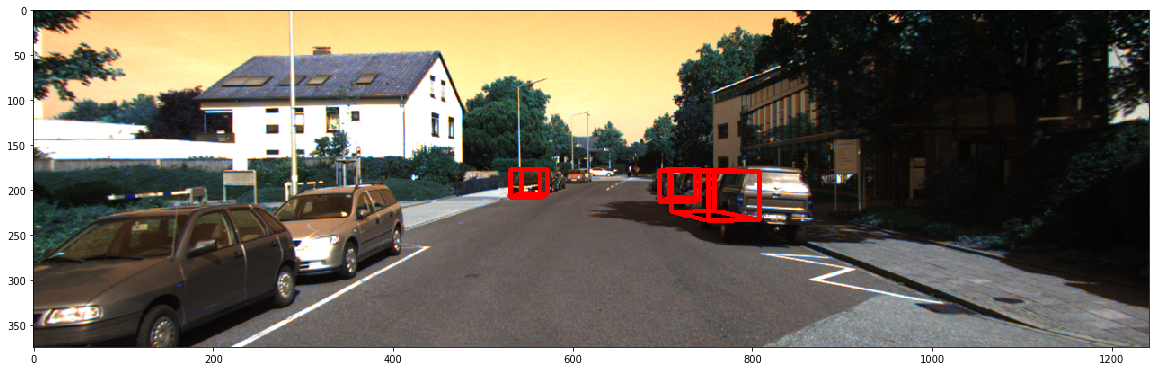

In [40]:
all_image = sorted(os.listdir(image_dir))
#np.random.shuffle(all_image)

for f in all_image:
    image_file = image_dir + f
    calib_file = calib_dir + f.replace('png', 'txt')
    predi_file = predi_dir + f.replace('png', 'txt')

    # read calibration data
    for line in open(calib_file):
        if 'P2:' in line:
            cam_to_img = line.strip().split(' ')
            cam_to_img = np.asarray([float(number) for number in cam_to_img[1:]])
            cam_to_img = np.reshape(cam_to_img, (3,4))
        
        #if 'R0_rect:' in line:
        #    R0_rect = line.strip().split(' ')
        #    R0_rect = np.asarray([float(number) for number in R0_rect[1:]])
        #    R0_rect = np.reshape(R0_rect, (3,3))

        #if 'Tr_velo_to_cam:' in line:
        #    Tr_velo_to_cam = line.strip().split(' ')
        #    Tr_velo_to_cam = np.asarray([float(number) for number in Tr_velo_to_cam[1:]])
        #    Tr_velo_to_cam = np.reshape(Tr_velo_to_cam, (3,4))

    #R0_rect = np.append(R0_rect, np.zeros((3,1)), axis=1)
    #R0_rect = np.append(R0_rect, np.zeros((1,4)), axis=0)
    #R0_rect[-1,-1] = 1

    #Tr_velo_to_cam = np.append(Tr_velo_to_cam, np.zeros((1,4)), axis=0)
    #Tr_velo_to_cam[-1,-1] = 1

# draw 2D boxes and 3D boxes
image = cv2.imread(image_path + dataset[index] + '.png')
cars = []

for line in open(label_path + dataset[index] + '.txt').readlines():
    line = line.strip().split(' ')
    
    if 'Car' in line[0]:
        # Draw 2D Bounding Box
        x_min, y_min, x_max, y_max = [int(float(number)) for number in line[4:8]]
        #cv2.rectangle(image, (x_min,y_min), (x_max,y_max), (255,255,0), 3)

        # Draw 3D Bounding Box
        dims   = np.asarray([float(number) for number in line[8:11]])
        center = np.asarray([float(number) for number in line[11:14]])
        
        if np.abs(float(line[3])) < 0.01:
            continue
        print line[3], center
        
        rot_y  = float(line[3]) + np.arctan(center[0]/center[2])#float(line[14])
        
        box_3d = []

        for i in [1,-1]:
            for j in [1,-1]:
                for k in [0,1]:
                    point = np.copy(center)
                    point[0] = center[0] + i * dims[1]/2 * np.cos(-rot_y+np.pi/2) + (j*i) * dims[2]/2 * np.cos(-rot_y)
                    point[2] = center[2] + i * dims[1]/2 * np.sin(-rot_y+np.pi/2) + (j*i) * dims[2]/2 * np.sin(-rot_y)                  
                    point[1] = center[1] - k * dims[0]

                    point = np.append(point, 1)
                    point = np.dot(cam_to_img, point)
                    point = point[:2]/point[2]
                    point = point.astype(np.int16)
                    box_3d.append(point)

        for i in xrange(4):
            point_1_ = box_3d[2*i]
            point_2_ = box_3d[2*i+1]
            cv2.line(image, (point_1_[0], point_1_[1]), (point_2_[0], point_2_[1]), (255,0,0), 3)
            
        for i in xrange(8):
            point_1_ = box_3d[i]
            point_2_ = box_3d[(i+2)%8]
            cv2.line(image, (point_1_[0], point_1_[1]), (point_2_[0], point_2_[1]), (255,0,0), 3)
            
fig = plt.figure(figsize=(20,20))
plt.imshow(image); plt.show()